# Problem statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

####Task1 Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import os
import cv2
import PIL

import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Importing/mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#Grive Dataset directory

!ls /content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration

Test  Train


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test")

Check whether the data has been extracted successfully.

In [5]:
# Train and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images:\t", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images:\t", image_count_test)

Train images:	 2239
Test images:	 118


#### **Task 2: Loading the images using keras.preprocessing**

Defined parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

Using 80% of the images for training, and 20% for validation.

In [7]:
## train dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## validation dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Listed out all the classes of skin cancer and stored them in a list

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### **Task 3: Visualize the data**

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

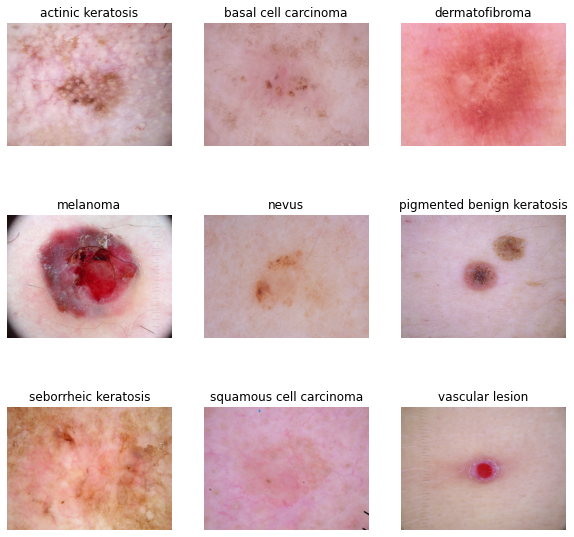

In [10]:
#Plotting image for each class

plt.figure(figsize=(10, 10))
for i, label in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), label)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.show()

#### Configure the dataset for performance
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Task 4: Model Building & training**
<b>Todo</b>: Create a CNN model, which can accurately detect 9 classes present in the dataset. 


* Note: The RGB channel values are in the `[0, 255]` range. 
* This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]`.
* Use `layers.experimental.preprocessing.Rescaling` for this purpose.

In [12]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [13]:
###Model Building:
#####Data Sequential -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Flatten -> Dense -> Dropout -> Dense

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [14]:
### Compile Model
model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])


In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 90, 90, 32)        0         
                                                        

##Training the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 729s 3s/step - loss: 2.0652 - accuracy: 0.2054 - val_loss: 1.9041 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.9018 - accuracy: 0.3036 - val_loss: 1.6946 - val_accuracy: 0.3982
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.7346 - accuracy: 0.3677 - val_loss: 1.5019 - val_accuracy: 0.5369
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5783 - accuracy: 0.4498 - val_loss: 1.4897 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4483 - accuracy: 0.4955 - val_loss: 1.3445 - val_accuracy: 0.5548
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4283 - accuracy: 0.5061 - val_loss: 1.3514 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3566 - accuracy: 0.5329 - val_loss: 1.4391 - val_accuracy: 0.5145
Epoch 8/20
56

#### Visualizing training results

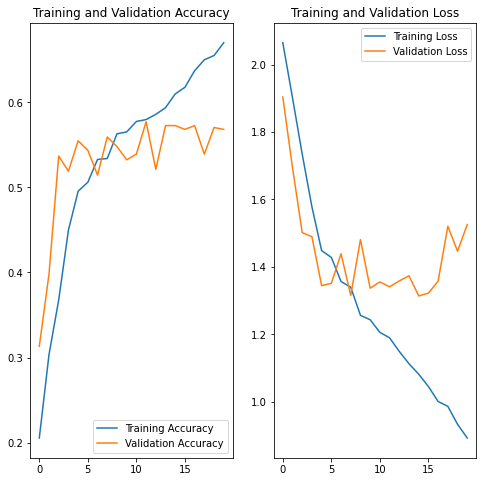

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Question**:
Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [18]:
print("Training Accuracy:",history.history['accuracy'][-1])
print("Validation Accuracy:",history.history['val_accuracy'][-1])

Training Accuracy: 0.6702008843421936
Validation Accuracy: 0.5682326555252075


####There is significant difference in training accuracy and validation accuracy. This is clear evidence of overfit since the training accuracy is higher than the validation accuracy.

### Task5: Data augmentation
Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [19]:
data_augmentation =  keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times

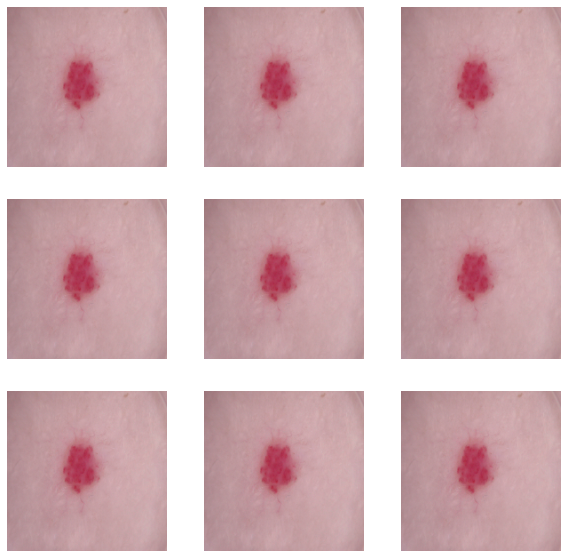

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### Task 6: Create, compile and train the model**


In [21]:
###Model Building:
##### Data Augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D ->
##### -> Flatten -> Dense -> Dropout -> Dense

model_aug = Sequential(data_augmentation)
model_aug.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model_aug.add(Conv2D(16, (3,3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Conv2D(32, (3,3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Conv2D(64, (3,3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.25))

model_aug.add(Flatten())
model_aug.add(Dense(128))
model_aug.add(Activation('relu'))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(num_classes))
model_aug.add(Activation('softmax'))

In [22]:
### Compile Model
model_aug.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])


In [23]:
# View the summary of all layers
model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_5 (Activation)   (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history_aug = model_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 29ms/step - loss: 2.0032 - accuracy: 0.2427 - val_loss: 1.8066 - val_accuracy: 0.3356
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.9712 - accuracy: 0.2606 - val_loss: 1.9137 - val_accuracy: 0.3087
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.8842 - accuracy: 0.3019 - val_loss: 1.9422 - val_accuracy: 0.3043
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.8012 - accuracy: 0.3471 - val_loss: 1.6437 - val_accuracy: 0.4362
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.7058 - accuracy: 0.3962 - val_loss: 1.6474 - val_accuracy: 0.3826
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5474 - accuracy: 0.4559 - val_loss: 1.5815 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5347 - accuracy: 0.4637 - val_loss: 1.4553 - val_accuracy: 0.5168
Epoch 8/20
56

#### Visualizing the results

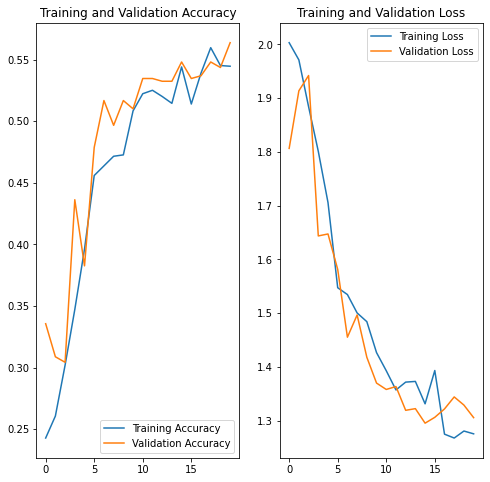

In [25]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Question**:
Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

In [26]:
print("Training Accuracy:",history_aug.history['accuracy'][-1])
print("Validation Accuracy:",history_aug.history['val_accuracy'][-1])

Training Accuracy: 0.5446428656578064
Validation Accuracy: 0.563758373260498


##### The training accuracy has reduced significantly but the validation has not changed reasonably and the difference betweent the training accuracy and validation accuracy is very minimal. Thus using image augmentation and Dropout, we have reduced overfitting compared to previous model.

#### Task7: Class distribution

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.



<b>Todo:</b> Find the distribution of classes in the training dataset.**

In [27]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(len(path_list))

2239


In [28]:
#create the dataframe containing all the path and their labels
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab_Notebooks/UpGrad...,actinic keratosis
1,/content/gdrive/MyDrive/Colab_Notebooks/UpGrad...,actinic keratosis
2,/content/gdrive/MyDrive/Colab_Notebooks/UpGrad...,actinic keratosis
3,/content/gdrive/MyDrive/Colab_Notebooks/UpGrad...,actinic keratosis
4,/content/gdrive/MyDrive/Colab_Notebooks/UpGrad...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Colab_Notebooks/UpGrad...,vascular lesion
2235,/content/gdrive/MyDrive/Colab_Notebooks/UpGrad...,vascular lesion
2236,/content/gdrive/MyDrive/Colab_Notebooks/UpGrad...,vascular lesion
2237,/content/gdrive/MyDrive/Colab_Notebooks/UpGrad...,vascular lesion


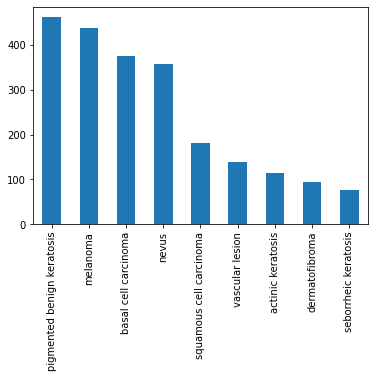

In [29]:
## Visualising the distribution of each labels from the dataframe

original_df["Label"].value_counts().plot(kind = 'bar')

#### **Questions:**  
 - Which class has the least number of samples?
 - Which classes dominate the data in terms proportionate number of samples?


##### 1. Seborrheic Keratosis has the least number of samples.

##### 2. Pigmented benign keratosis, melanoma and basal cell carcinoma has the highest proportion of data

#### **Task 8: Rectifying the class imbalance**
You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.<br>
<b>Todo:</b> Apply augmentor

In [30]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset= '/content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/'

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB1EDD1AC10>: 100%|██████████| 500/500 [00:19<00:00, 25.76 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB1EDD8A090>: 100%|██████████| 500/500 [00:23<00:00, 21.15 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB1EDD779D0>: 100%|██████████| 500/500 [00:25<00:00, 19.56 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB1ED9C6690>: 100%|██████████| 500/500 [01:31<00:00,  5.48 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2117x1988 at 0x7FB1EDF5D3D0>: 100%|██████████| 500/500 [01:27<00:00,  5.72 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB1EDF5D3D0>: 100%|██████████| 500/500 [00:18<00:00, 27.59 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB1EDDD4210>: 100%|██████████| 500/500 [00:42<00:00, 11.66 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB1EDDF8490>: 100%|██████████| 500/500 [00:18<00:00, 27.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB1ED53F050>: 100%|██████████| 500/500 [00:18<00:00, 26.86 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027580.jpg_52566041-276e-4da9-a5af-a8b51ab326b5.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_1465e357-7488-4a7d-a720-22d5b8a03bab.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029041.jpg_4922d094-50e0-4a38-bb3e-97c6d50c7359.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027829.jpg_aea173ca-0d8a-43a9-8a4a-418d3f13d709.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/UpGrad/Skin_cancer_ISIC_The_International_

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [35]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [37]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Task9: Model Building & training
<b>Todo:</b> Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

</b> Create a training dataset

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


</b> Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [41]:
###Model Building:
##### Data Augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D ->
##### -> Flatten -> Dense -> Dropout -> Dense

model_aug_classimb = Sequential(data_augmentation)
model_aug_classimb.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model_aug_classimb.add(Conv2D(16, (3,3), padding='same'))
model_aug_classimb.add(Activation('relu'))
model_aug_classimb.add(MaxPooling2D(pool_size=(2, 2)))

model_aug_classimb.add(Conv2D(32, (3,3), padding='same'))
model_aug_classimb.add(Activation('relu'))
model_aug_classimb.add(MaxPooling2D(pool_size=(2, 2)))

model_aug_classimb.add(Conv2D(64, (3,3), padding='same'))
model_aug_classimb.add(Activation('relu'))
model_aug_classimb.add(MaxPooling2D(pool_size=(2, 2)))
model_aug_classimb.add(Dropout(0.25))

model_aug_classimb.add(Flatten())
model_aug_classimb.add(Dense(128))
model_aug_classimb.add(Activation('relu'))
model_aug_classimb.add(Dropout(0.5))
model_aug_classimb.add(Dense(num_classes))
model_aug_classimb.add(Activation('softmax'))

In [42]:
### Compile Model
model_aug_classimb.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])


In [43]:
# View the summary of all layers
model_aug_classimb.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_10 (Activation)  (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

In [44]:
#Training the model

epochs = 30

history_aug_classimb = model_aug_classimb.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 43s 240ms/step - loss: 2.0327 - accuracy: 0.2125 - val_loss: 1.7104 - val_accuracy: 0.3705
Epoch 2/30
169/169 [==============================] - 31s 176ms/step - loss: 1.6690 - accuracy: 0.3628 - val_loss: 1.5009 - val_accuracy: 0.4321
Epoch 3/30
169/169 [==============================] - 31s 175ms/step - loss: 1.5723 - accuracy: 0.3867 - val_loss: 1.4506 - val_accuracy: 0.4707
Epoch 4/30
169/169 [==============================] - 37s 212ms/step - loss: 1.4996 - accuracy: 0.4119 - val_loss: 1.3411 - val_accuracy: 0.4647
Epoch 5/30
169/169 [==============================] - 30s 172ms/step - loss: 1.4519 - accuracy: 0.4360 - val_loss: 1.3424 - val_accuracy: 0.4655
Epoch 6/30
169/169 [==============================] - 31s 177ms/step - loss: 1.4254 - accuracy: 0.4466 - val_loss: 1.5427 - val_accuracy: 0.4246
Epoch 7/30
169/169 [==============================] - 30s 172ms/step - loss: 1.4012 - accuracy: 0.4629 - val_loss: 1.3474 - val_ac

</b>  Visualising the model results

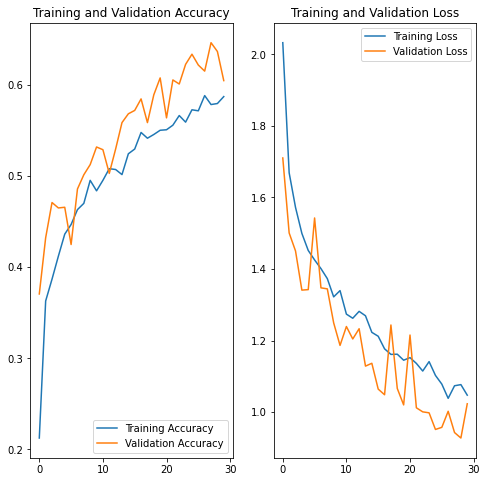

In [45]:
acc = history_aug_classimb.history['accuracy']
val_acc = history_aug_classimb.history['val_accuracy']

loss = history_aug_classimb.history['loss']
val_loss = history_aug_classimb.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Task 10: Analyzing the results

#### **Question:**
- Did you get rid of underfitting/overfitting from the model? 
- Did class rebalance help in the process?


In [46]:
print("Training Accuracy:",history_aug_classimb.history['accuracy'][-1])
print("Validation Accuracy:",history_aug_classimb.history['val_accuracy'][-1])

Training Accuracy: 0.5867952704429626
Validation Accuracy: 0.6043058633804321


After adding augmented images to manage class imbalance, the training accuracy and the validation accuracy has increased slightly and the difference betweent the training accuracy and validation accuracy is very minimal. Thus we have reduced overfitting compared to the first model and we can get higher accuracy with deeper layers.